India- clearing 

In [ ]:
import pandas as pd

#read a csv file 
df = pd.read_csv("Karnataka_india.csv")

#delete columns
df = df.drop(columns=['Amb_Temp', 'AC Ir in Amps', 'AC Iy in Amps', 'AC Ib in Amps', 'DC Current in Amps'])

#delete the nan values from the dataframe
df = df.dropna()

#save corrected file
df.to_csv("Karnataka_india_cleared.csv", index=False)

#info
print(df.info())
print(df.head())
print(df.describe())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118865 entries, 0 to 118864
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MODULE_TEMP        118865 non-null  float64
 1   WIND_Speed         118865 non-null  float64
 2   IRR (W/m2)         118865 non-null  float64
 3   AC Power in Watts  118865 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 3.6 MB
None
   MODULE_TEMP  WIND_Speed  IRR (W/m2)  AC Power in Watts
0      18.7675    47.60506    6.388252               3233
1      18.6150    64.26684   12.776500               4504
2      18.9200    85.68912   17.035340               6614
3      18.9200    83.30886   25.553010               8971
4      19.0725    57.12608   36.200090              12071
         MODULE_TEMP     WIND_Speed     IRR (W/m2)  AC Power in Watts
count  118865.000000  118865.000000  118865.000000      118865.000000
mean       37.141972     224.429052     428.093276   

Analyze for India

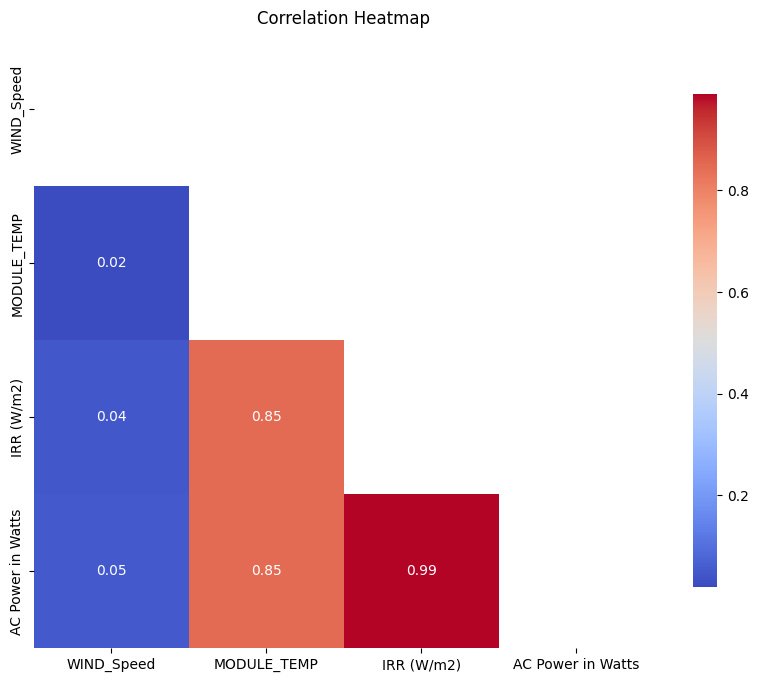

KeyError: ' Solar irradiance (W/m2) '

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

#read csv file
df = pd.read_csv("Karnataka_india_cleared.csv")
'''
#histogram of IRR (W/m2)
plt.hist(df[' IRR (W/m2) '], bins=50)
plt.xlabel('Solar irradiance (W/m2)')
plt.ylabel('Frequency')
plt.title('Histogram of solar irradiance')
plt.show()

#histogram of AC Power in Watts and present in kW
plt.hist(df[' AC Power in Watts'] / 1000, bins=50)
plt.xlabel('AC power (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of AC power')
plt.show()

#histogram of MODULE_TEMP
plt.hist(df['MODULE_TEMP'], bins=50)
plt.xlabel('Module temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of module temperature')
plt.show()

#2D histogram of AC Power in Watts and IRR (W/m2)
plt.hist2d(df['IRR (W/m2)'], df['AC Power in Watts'] / 1000, bins=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Solar irradiance (W/m2)')
plt.ylabel('AC power (kW)')
plt.title('2D Histogram of AC power vs solar irradiance')
plt.show()
'''

#correlation heatmap with WIND_Speed, MODULE_TEMP, IRR (W/m2), AC Power in Watts
correlation_matrix = df[['WIND_Speed', 'MODULE_TEMP', 'IRR (W/m2)', 'AC Power in Watts']].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

#division of the data into 2 file
df_high_irr = df[df[' Solar irradiance (W/m2) '] > 150]
df_low_irr = df[df[' Solar irradiance (W/m2) '] <= 150]
df_high_irr.to_csv("Karnataka_india_high_irr.csv", index=False)
df_low_irr.to_csv("Karnataka_india_low_irr.csv", index=False)



India- analysis for low irriadance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#read csv file 
df = pd.read_csv("Karnataka_india_low_irr.csv")
#delete columns: 'Amb_Temp', 'AC Ir in Amps', 'AC Iy in Amps', 'AC Ib in Amps'
df = df.drop(columns=[' AC Ir in Amps', ' AC Iy in Amps', ' AC Ib in Amps'])

#Histogram of AC Power in Watts, Module_Temp and IRR (W/m2)
plt.hist(df[' AC Power in Watts']/ 1000, bins=50)
plt.xlabel(' AC power (kW) ')
plt.ylabel('Frequency')
plt.title('Histogram of AC power (Low IRR)')
plt.show()

#Histogram of IRR (W/m2)
plt.hist(df[' IRR (W/m2) '], bins=50)
plt.xlabel(' Solar irradiance (W/m2) ')
plt.ylabel('Frequency')
plt.title('Histogram of solar irradiance (Low IRR)')
plt.show()

#Histogram of MODULE_TEMP
plt.hist(df['MODULE_TEMP'], bins=50)
plt.xlabel('Module temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of module temperature (Low IRR)')
plt.show()

#Correlation heatmap with WIND_Speed, MODULE_TEMP, IRR (W/m2), AC Power in Watts
correlation_matrix = df[[' WIND_Speed ', 'MODULE_TEMP', ' IRR (W/m2) ', ' AC Power in Watts']].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap (Low IRR)')
plt.show()


        MODULE_TEMP   WIND_Speed    IRR (W/m2)    DC Current in Amps  \
count  28932.000000  28932.000000  28932.000000         28932.000000   
mean      23.630975    174.071141     72.006866            53.441776   
std        4.545063    187.211969     40.599052            39.995355   
min        8.855000      0.238025      2.129417             0.600000   
25%       20.292500     23.802530     38.329510            10.880000   
50%       22.732500     59.268310     68.141360            52.430000   
75%       26.545000    309.432900    106.470900            85.240000   
max       58.722500    595.063300    149.059200           287.440000   

        AC Power in Watts  
count        28932.000000  
mean         21850.085580  
std          13345.592842  
min            394.000000  
25%          10153.750000  
50%          19806.000000  
75%          32281.000000  
max         107709.000000  


'\n#Histogram of AC Power in Watts, Module_Temp and IRR (W/m2)\nplt.hist(df[\' AC Power in Watts\']/ 1000, bins=50)\nplt.xlabel(\' AC power (kW) \')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of AC power (Low IRR)\')\nplt.show()\n\n#Histogram of IRR (W/m2)\nplt.hist(df[\' IRR (W/m2) \'], bins=50)\nplt.xlabel(\' Solar irradiance (W/m2) \')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of solar irradiance (Low IRR)\')\nplt.show()\n\n#Histogram of MODULE_TEMP\nplt.hist(df[\'MODULE_TEMP\'], bins=50)\nplt.xlabel(\'Module temperature (°C)\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of module temperature (Low IRR)\')\nplt.show()\n\n#Correlation heatmap with WIND_Speed, MODULE_TEMP, IRR (W/m2), AC Power in Watts\ncorrelation_matrix = df[[\' WIND_Speed \', \'MODULE_TEMP\', \' IRR (W/m2) \', \' AC Power in Watts\']].corr()\nmask = np.zeros_like(correlation_matrix)\nmask[np.triu_indices_from(mask)] = True\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, mask=mask,

India analysis for high irradiance

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#read csv file 
df = pd.read_csv("Karnataka_india_high_irr.csv")

#delete columns: 'Amb_Temp', 'AC Ir in Amps', 'AC Iy in Amps', 'AC Ib in Amps'
df = df.drop(columns=[' AC Ir in Amps', ' AC Iy in Amps', ' AC Ib in Amps'])

#descripction
print(df.describe())

#2D histogram of AC Power in Watts and IRR (W/m2), power in kW
plt.hist2d(df[' IRR (W/m2)'], df[' AC Power in Watts'] / 1000, bins=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Solar irradiance (W/m2)')
plt.ylabel('AC power (kW)')
plt.title('2D Histogram of AC power vs solar irradiance (High IRR )')
plt.show()

#Histogram of AC Power in Watts, Module_Temp and IRR (W/m2)
plt.hist(df[' AC Power in Watts'] /1000, bins=50)
plt.xlabel(' AC power (kW) ')
plt.ylabel('Frequency')
plt.title('Histogram of AC power (High IRR )')
plt.show()

#Histogram of IRR (W/m2)
plt.hist(df[' IRR (W/m2)'], bins=50)
plt.xlabel(' Solar irradiance (W/m2) ')
plt.ylabel('Frequency')
plt.title('Histogram of solar irradiance (High IRR)')
plt.show()

#Histogram of MODULE_TEMP
plt.hist(df['MODULE_TEMP'], bins=50)
plt.xlabel('Module temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of module temperature (High IRR)')
plt.show()

#Correlation heatmap
correlation_matrix = df[[' WIND_Speed ', 'MODULE_TEMP', ' IRR (W/m2)', ' AC Power in Watts']].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap (High IRR)')
plt.show()


        MODULE_TEMP   WIND_Speed     IRR (W/m2)   DC Current in Amps  \
count  89933.000000  89933.000000  89933.000000         89933.000000   
mean      41.488543    240.629502    542.648467           453.205411   
std       10.326181    240.229471    274.360621           230.885302   
min       13.430000      0.238025    151.188600             2.040000   
25%       33.560000     29.277110    300.247900           248.260000   
50%       41.337490     59.030280    489.766000           409.660000   
75%       49.420000    549.838500    787.884300           663.360000   
max       72.447500    597.443500   1494.851000           995.679988   

        AC Power in Watts  
count        89933.000000  
mean        162256.376914  
std          78332.337125  
min           7867.000000  
25%          92415.000000  
50%         150186.000000  
75%         234171.000000  
max         332614.000000  


'\n#2D histogram of AC Power in Watts and IRR (W/m2), power in kW\nplt.hist2d(df[\' IRR (W/m2)\'], df[\' AC Power in Watts\'] / 1000, bins=50, cmap=\'Blues\')\nplt.colorbar(label=\'Counts\')\nplt.xlabel(\'Solar irradiance (W/m2)\')\nplt.ylabel(\'AC power (kW)\')\nplt.title(\'2D Histogram of AC power vs solar irradiance (High IRR )\')\nplt.show()\n\n#Histogram of AC Power in Watts, Module_Temp and IRR (W/m2)\nplt.hist(df[\' AC Power in Watts\'] /1000, bins=50)\nplt.xlabel(\' AC power (kW) \')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of AC power (High IRR )\')\nplt.show()\n\n#Histogram of IRR (W/m2)\nplt.hist(df[\' IRR (W/m2)\'], bins=50)\nplt.xlabel(\' Solar irradiance (W/m2) \')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of solar irradiance (High IRR)\')\nplt.show()\n\n#Histogram of MODULE_TEMP\nplt.hist(df[\'MODULE_TEMP\'], bins=50)\nplt.xlabel(\'Module temperature (°C)\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of module temperature (High IRR)\')\nplt.show()

Cleaning Denmark

In [1]:
import pandas as pd

# read with semicolon separator and comma decimal (European format)
df = pd.read_csv("Denmark_Kalundbor.csv", sep=';', decimal=',', engine='python', encoding='utf-8')

# normalize column names
df.columns = df.columns.str.strip()

# rename columns 
df = df.rename(columns={
    'PCTimeStamp': 'Date_and_time',
    'WTG01_Ambient WindSpeed Avg. (1)': 'Wind_speed_average',
    'WTG01_Blades PitchAngle Avg. (2)': 'Blade_pitch_angle',
    'WTG01_Grid Production Power Avg. (3)': 'Power_output_average'
})

# parse datetime (day-first) and coerce malformed values to NaT
if 'Date_and_time' in df.columns:
    df['Date_and_time'] = pd.to_datetime(df['Date_and_time'].astype(str).str.strip(), dayfirst=True, errors='coerce')

# coerce numeric columns to floats 
for col in ['Wind_speed_average', 'Power_output_average']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.strip().str.replace(',', '.', regex=False), errors='coerce')

# drop column 
df = df.drop(columns=['Blade_pitch_angle'], errors='ignore')

# drop rows missing essential data (datetime, wind or power)
df = df.dropna(subset=[c for c in ['Date_and_time', 'Wind_speed_average', 'Power_output_average'] if c in df.columns], how='any')

# save the cleaned file
df.to_csv("Denmark_Kalundborg_cleared.csv", sep=';', index=False)

#info
print(df.info())
print(df.describe())
print(df.head())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 1726 entries, 0 to 250560
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_and_time         1726 non-null   datetime64[ns]
 1   Wind_speed_average    1726 non-null   float64       
 2   Power_output_average  1726 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 53.9 KB
None
                       Date_and_time  Wind_speed_average  Power_output_average
count                           1726         1726.000000           1726.000000
mean   2022-04-15 03:37:45.121668608            6.176999            628.557358
min              2019-12-01 00:00:00            0.100000            -24.400000
25%              2021-02-05 06:00:00            4.400000            135.775000
50%              2022-04-12 12:00:00            5.800000            418.650000
75%              2023-06-21 18:00:00            7.600000            

Denmark analysis

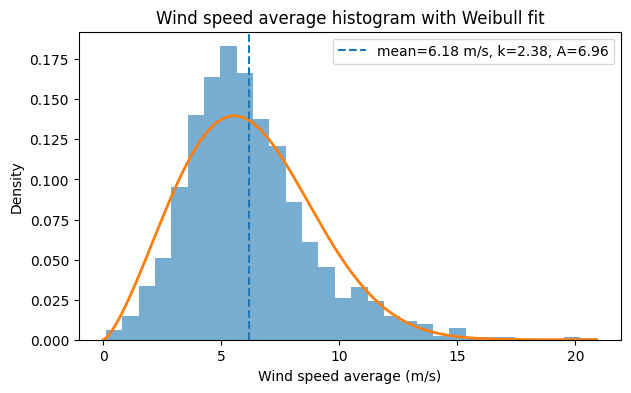

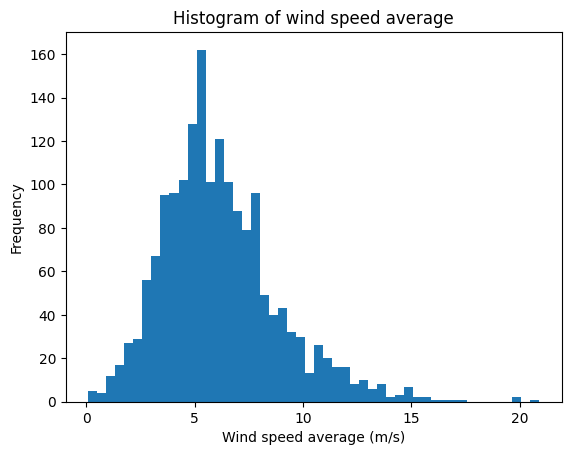

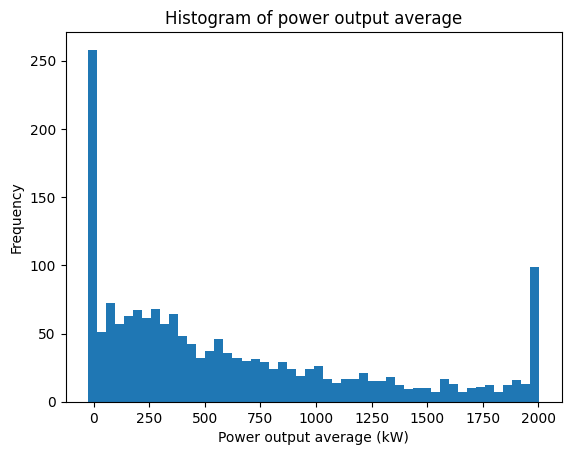

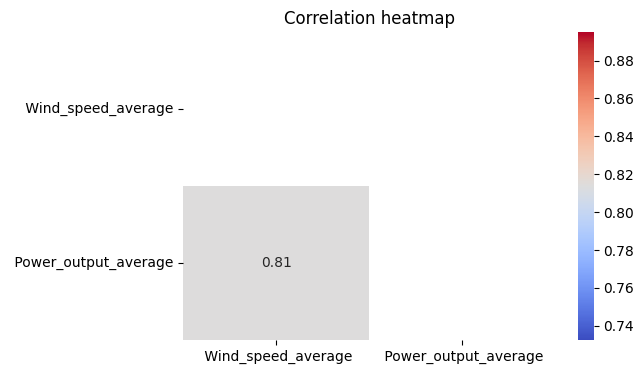

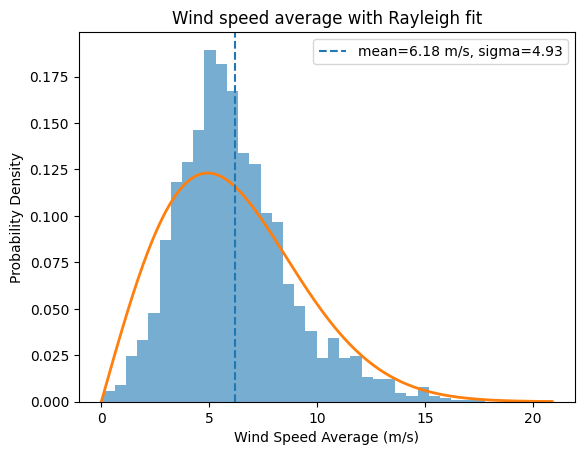

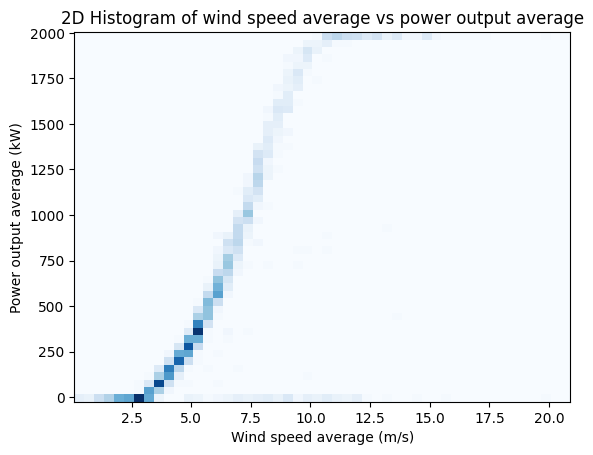

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#read csv file "Denmark_Kalundborg_cleared.csv"
df = pd.read_csv("Denmark_Kalundborg_cleared.csv", sep=';', decimal=',', engine='python', encoding='utf-8')

from scipy.stats import weibull_min
ws = df[' Wind_speed_average'].dropna()
k, loc, A = weibull_min.fit(ws, floc=0)
x = np.linspace(0, ws.max(), 200)
pdf = weibull_min.pdf(x, k, loc=loc, scale=A)
plt.figure(figsize=(7,4))
plt.hist(ws, bins=30, density=True, alpha=0.6)
plt.plot(x, pdf, lw=2)
plt.axvline(ws.mean(), ls='--', label=f'mean={ws.mean():.2f} m/s, k={k:.2f}, A={A:.2f}')
plt.title('Wind speed average histogram with Weibull fit')
plt.legend()
plt.xlabel('Wind speed average (m/s)')
plt.ylabel('Density')
plt.show()

#histogram of Wind_speed_average
plt.hist(df[' Wind_speed_average'], bins=50)
plt.xlabel('Wind speed average (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of wind speed average')
plt.show()

#histogram of Power_output
plt.hist(df[' Power_output_average'], bins=50)
plt.xlabel('Power output average (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of power output average')
plt.show()

#correlation heatmap 
mask = np.zeros_like(df[[' Wind_speed_average', ' Power_output_average']].corr())
mask[np.triu_indices_from(mask)] = True
correlation_matrix = df[[' Wind_speed_average', ' Power_output_average']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation heatmap')
plt.show()

#Wind speed distribution fitting with Rayleigh distribution
from scipy.stats import rayleigh
mu = df[' Wind_speed_average'].mean()
sigma = mu / np.sqrt(np.pi/2)
x = np.linspace(0, df[' Wind_speed_average'].max(), 500)
pdf = rayleigh(scale=sigma).pdf(x)
plt.hist(df[' Wind_speed_average'], bins=40, density=True, alpha=0.6)
plt.plot(x, pdf, linewidth=2)
plt.axvline(mu, ls='--', label=f'mean={mu:.2f} m/s, sigma={sigma:.2f}')
plt.legend()
plt.xlabel("Wind Speed Average (m/s)")
plt.ylabel("Probability Density")
plt.title("Wind speed average with Rayleigh fit")
plt.show()

#2D histogram of Wind_speed and Power_output
plt.hist2d(df[' Wind_speed_average'], df[' Power_output_average'], bins=50, cmap='Blues')
plt.xlabel('Wind speed average (m/s)')
plt.ylabel('Power output average (kW)')
plt.title('2D Histogram of wind speed average vs power output average') 
plt.show()

Clean Turkey

In [ ]:
import pandas as pd

#read a csv file "Yalova Tureky.csv"
df = pd.read_csv("Yalova Tureky.csv")

#delete column
df = df.drop(columns=['Wind Direction (°)'], errors='ignore')

#change columns names
df = df.rename(columns={
    'Date & Time': 'Date_and_time',
    'Wind Speed (m/s)': 'Wind_speed',
    'LV ActivePower (kW)': 'Active_Power',
    'Theoretical_Power_Curve (KWh)': 'Theoretical_Power_Curve'
})  

#delete nan values from the dataframe
df = df.dropna()

#save the file as "Yalova_Turkey_cleared.csv"
df.to_csv("Yalova_Turkey_cleared.csv", index=False)

#info
print(df.info())
print(df.describe())
print(df.head())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date/Time                50530 non-null  object 
 1   Active_Power             50530 non-null  float64
 2   Wind_speed               50530 non-null  float64
 3   Theoretical_Power_Curve  50530 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB
None
       Active_Power    Wind_speed  Theoretical_Power_Curve
count  50530.000000  50530.000000             50530.000000
mean    1307.684332      7.557952              1492.175463
std     1312.459242      4.227166              1368.018238
min       -2.471405      0.000000                 0.000000
25%       50.677890      4.201395               161.328167
50%      825.838074      7.104594              1063.776283
75%     2482.507568     10.300020              2964.972462
max     3618.732910     25.206011      

Analysis for the Turkey

Columns: ['Date/Time', 'Active_Power', 'Wind_speed', 'Theoretical_Power_Curve']


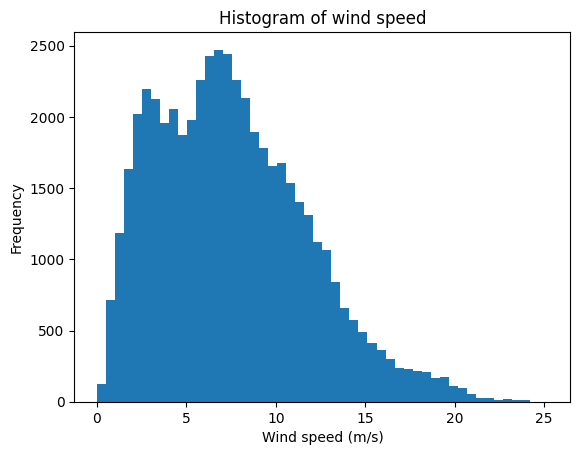

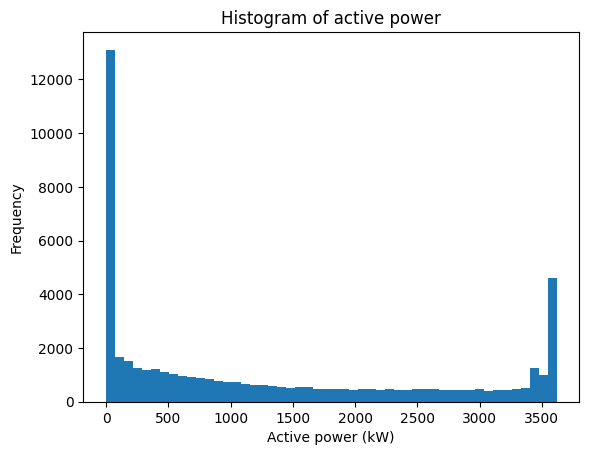

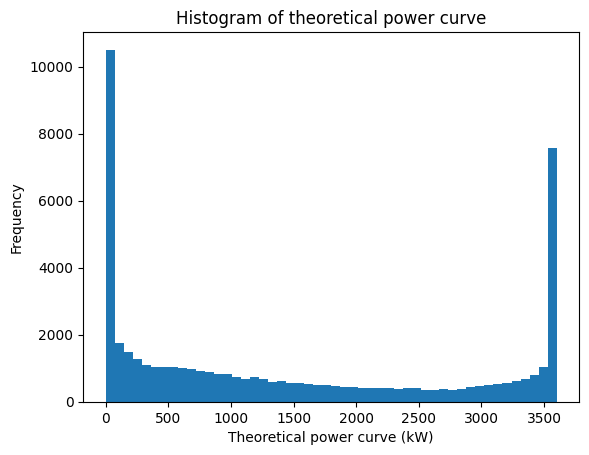

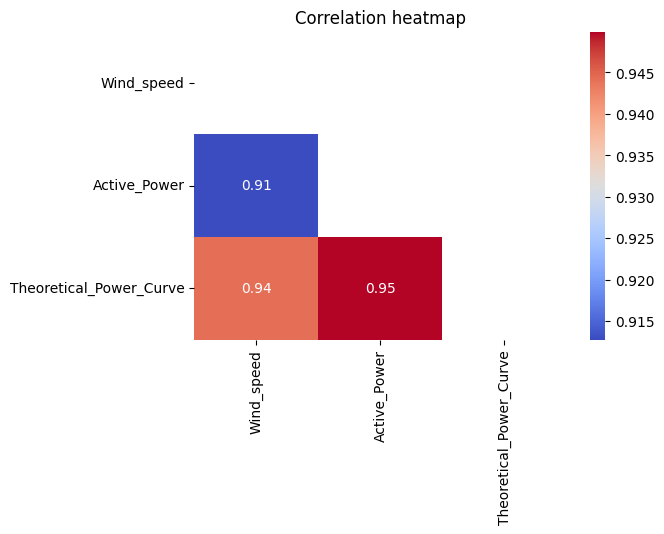

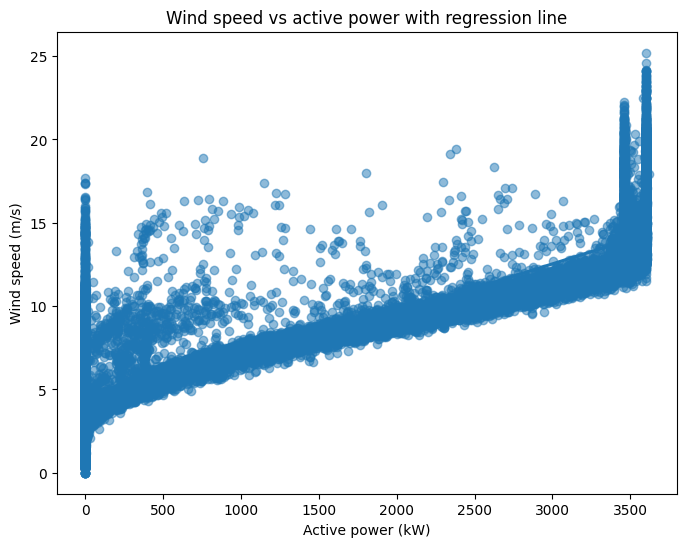

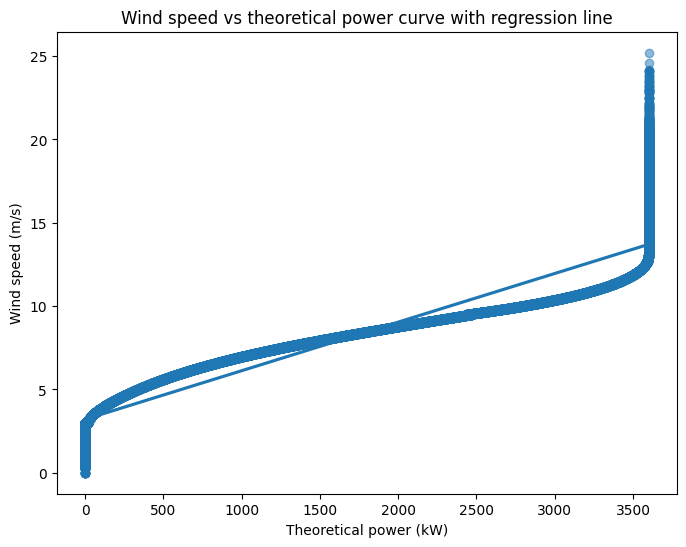

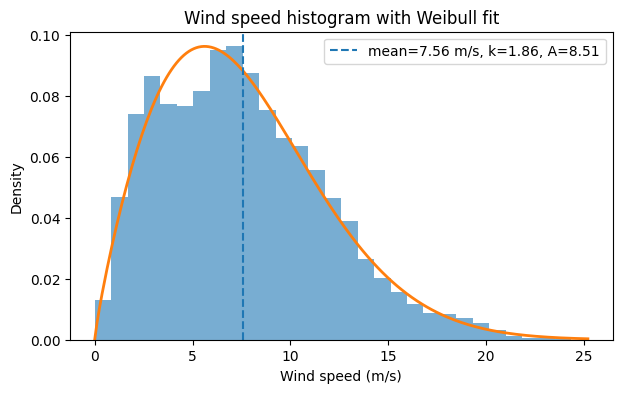

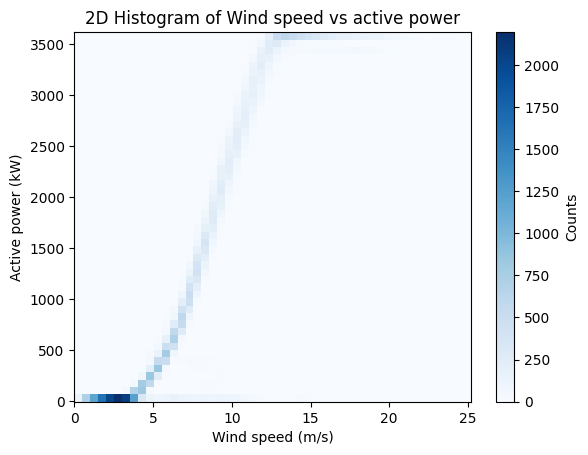

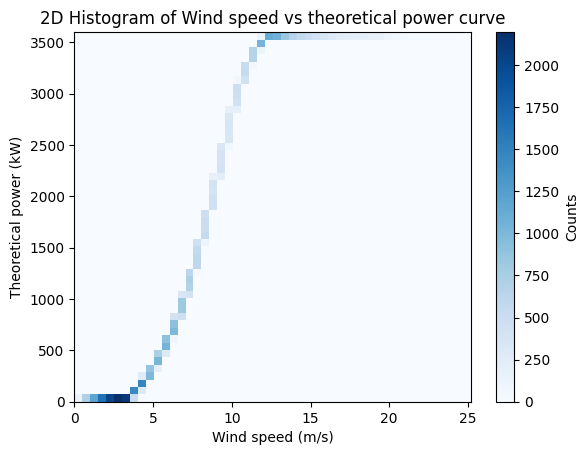

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import weibull_min

# read CSV and strip spaces after delimiters so column names are clean
df = pd.read_csv("Yalova_Turkey_cleared.csv", skipinitialspace=True)
df.columns = df.columns.str.strip()

#check of column names
print('Columns:', df.columns.tolist())

#Histogram of Wind_speed 
plt.hist(df['Wind_speed'], bins=50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of wind speed')
plt.show()

#histogram of  Active_Power
plt.hist(df['Active_Power'], bins=50)
plt.xlabel('Active power (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of active power')
plt.show()

#historgram of Theoretical_Power
plt.hist(df['Theoretical_Power_Curve'], bins=50)
plt.xlabel('Theoretical power curve (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of theoretical power curve')
plt.show()

#correlation heatmap 
mask = np.zeros((3, 3), dtype=bool)
mask[np.triu_indices_from(mask)] = True
correlation_matrix = df[['Wind_speed', 'Active_Power', 'Theoretical_Power_Curve']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation heatmap')
plt.show()

#Wind speed with Weibull fit
from scipy.stats import weibull_min
ws = df['Wind_speed'].dropna()
k, loc, A = weibull_min.fit(ws, floc=0)
x = np.linspace(0, ws.max(), 200)
pdf = weibull_min.pdf(x, k, loc=loc, scale=A)
plt.figure(figsize=(7,4))
plt.hist(ws, bins=30, density=True, alpha=0.6)
plt.plot(x, pdf, lw=2)
plt.axvline(ws.mean(), ls='--', label=f'mean={ws.mean():.2f} m/s, k={k:.2f}, A={A:.2f}')
plt.title('Wind speed histogram with Weibull fit')
plt.legend()
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Density')
plt.show()

#2D histogram of Wind_speed vs Active_Power
plt.hist2d(df['Wind_speed'], df['Active_Power'], bins=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Active power (kW)')
plt.title('2D Histogram of Wind speed vs active power')
plt.show()

#2D histogrmam of Wind_speed vs Theoretical_Power_Curve
plt.hist2d(df['Wind_speed'], df['Theoretical_Power_Curve'], bins=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Theoretical power (kW)')
plt.title('2D Histogram of Wind speed vs theoretical power curve')
plt.show()

Massachusett clean solar

In [7]:
import pandas as pd

#read csv file
df = pd.read_csv("Massachusett_solar.csv")

#delete columns:  
df = df.drop(columns=[
    'Day of Week', 'Is Weekend', 'Is Holiday','Season', 'Week of Year','Historical Electricity Load (kW)',
    'Peak Load Indicator', 'Load Sector Type', 'Transformer Load Level','Voltage Level (V)', 
    'Current Level (A)', 'Power Factor','Substation ID / Region ID', 'Demand Response Signal (Binary)',
    'Grid Frequency (Hz)', 'Wind Power Output (kW)','Solar Panel Temperature (°C)', 'Wind Direction (degrees)', 
    'Inverter Efficiency (%)','Battery State of Charge (SOC) (%)', 'Battery Discharge Rate (kW/h)',
    'Renewable Forecast Error', 'Curtailment Event Flag','Cloud Cover (%)', 'Rainfall (mm)', 'Snowfall (mm)', 
    'Visibility (km)','Weather Condition', 'Atmospheric Pressure (hPa)', 'Dew Point (°C)',
    'Smart Meter Reading per Building (kW)', 'Building Type (Encoded)','Building Occupancy Rate (%)', 
    'Public Transit Operational Load (kW)','EV Charging Station Load (kW)', 'EV Charging Session Count',
    'Traffic Congestion Index', 'Human Mobility Score', 'Region Urban Density Index', 
    'Construction or Maintenance Activity Flag', 'Time Since Last Peak (hours)','Time Until Next Predicted Peak (hours)',
      'Region/Zone ID', 'Latitude','Longitude', 'Altitude (m)', 'Distance to Nearest Substation (km)', 'Area Type', 
      'Electricity Load', 'Renewable Energy Load', 'Net Load','Curtailment Risk / Surplus Flag', 'Month', 'Hour of Day'
], errors='ignore')     

#delete nan values from the dataframe
df = df.dropna()

#cut the impossible solar irradiance values 
df = df.drop(df[df['Solar Irradiance (W/m²)'] > 1400].index)

#save the file as "Massachusett_solar_cleared_separated.csv"
df.to_csv("Massachusett_solar_cleared.csv", index=False)

print(df.describe())

       Solar PV Output (kW)  Wind Speed (m/s)  Temperature (°C)  Humidity (%)  \
count          72294.000000      72294.000000      72294.000000  72294.000000   
mean              49.959226          5.004049         20.005302     28.555841   
std               50.392325          5.005992         10.020431     15.975096   
min                0.000215          0.000113        -19.623270      0.079897   
25%               14.392792          1.434059         13.217511     16.130482   
50%               34.446328          3.465121         20.025764     26.355225   
75%               68.787736          6.944948         26.820018     38.867657   
max              589.844639         62.166880         62.065148     90.533259   

       Solar Irradiance (W/m²)  
count             72294.000000  
mean                287.929260  
std                 268.123502  
min                   0.009583  
25%                  85.808650  
50%                 206.239058  
75%                 409.946105  
max   

Massachusett analysis

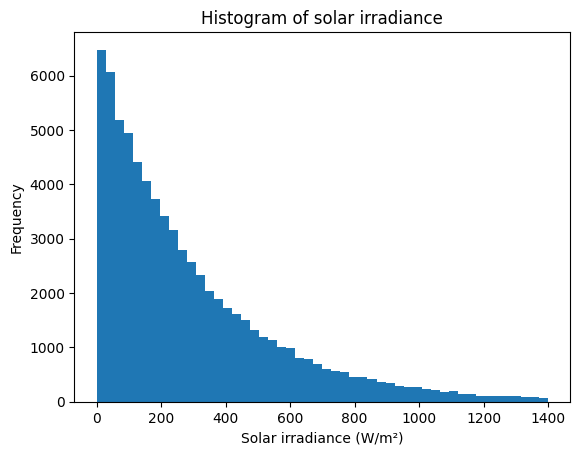

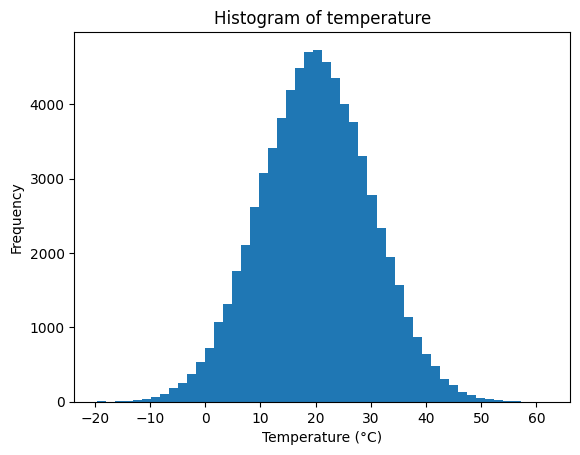

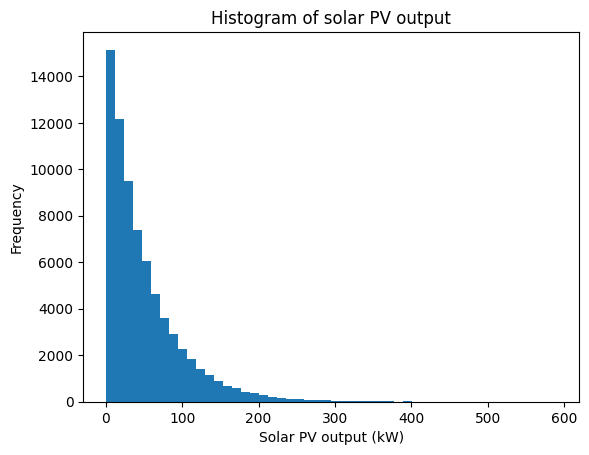

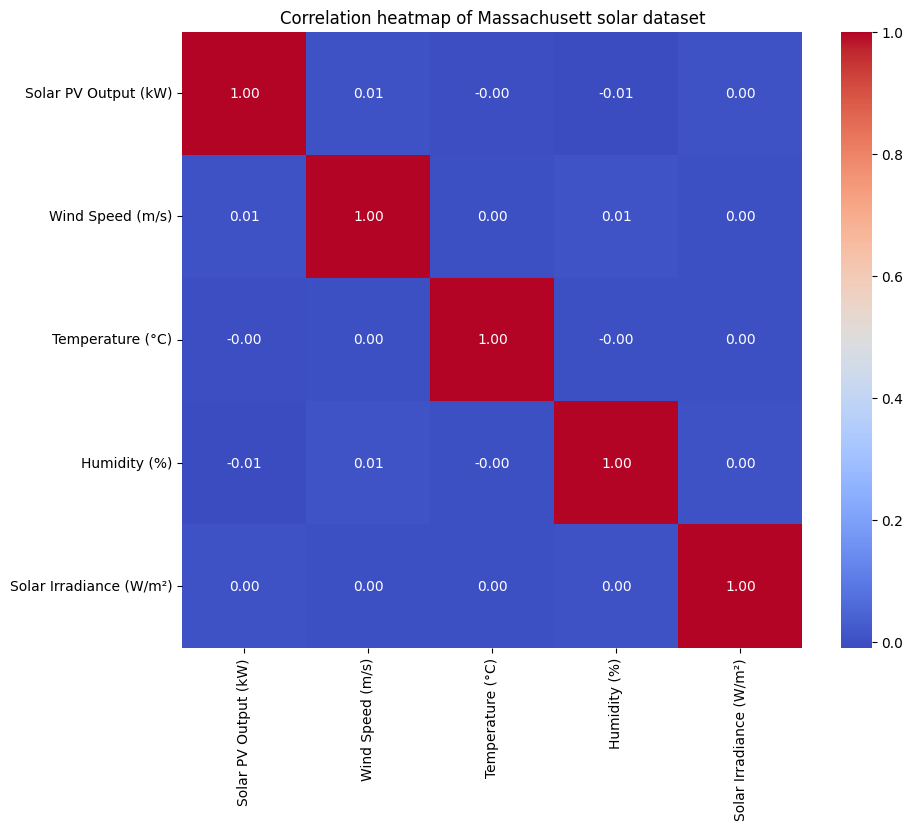

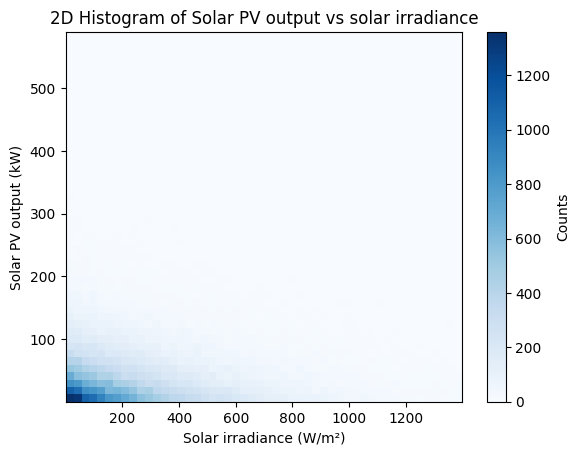

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#read CSV 
df = pd.read_csv("Massachusett_solar_cleared.csv")
df.columns = df.columns.str.strip()

#cut the impossible solar irradiance values 
df = df.drop(df[df['Solar Irradiance (W/m²)'] > 1400].index)

#histogram of Solar Irradiance (W/m2)
plt.hist(df['Solar Irradiance (W/m²)'], bins=50)
plt.xlabel('Solar irradiance (W/m²)')
plt.ylabel('Frequency')
plt.title('Histogram of solar irradiance')
plt.show()

#histogram of Temperature (°C)
plt.hist(df['Temperature (°C)'], bins=50)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of temperature')
plt.show()

#histogram of Solar PV Output (kW)
plt.hist(df['Solar PV Output (kW)'], bins=50)
plt.xlabel('Solar PV output (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of solar PV output')
plt.show()

#correlative heatmap
correlation_matrix = df.drop(columns=['Timestamp'], errors='ignore').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap of Massachusett solar dataset')
plt.show()

#2D histogram Solar Irradiance vs Solar PV Output
plt.hist2d(df['Solar Irradiance (W/m²)'], df['Solar PV Output (kW)'], bins=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Solar irradiance (W/m²)')
plt.ylabel('Solar PV output (kW)')
plt.title('2D Histogram of Solar PV output vs solar irradiance')
plt.show()

USA my division 

In [ ]:
#read csv file "Massachusett_solar_cleared.csv"
import pandas as pd
df = pd.read_csv("Massachusett_solar_cleared.csv")
print(df.columns)
print(df.info())
print(df.describe())
print(df.head())

#drop values above 1500 in 'Solar Irradiance (W/m²) 
df = df[df['Solar Irradiance (W/m²)'] <= 1500]
   
#divide the data into 2 csv file
df_high_irr = df[df['Solar Irradiance (W/m²)'] > 150]
df_low_irr = df[df['Solar Irradiance (W/m²)'] <= 150]
df_high_irr.to_csv("USA_high_IRR.csv", index=False)
df_low_irr.to_csv("USA_low_irr.csv", index=False)


Index(['Timestamp', 'Solar PV Output (kW)', 'Wind Speed (m/s)',
       'Temperature (°C)', 'Humidity (%)', 'Solar Irradiance (W/m²)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72960 entries, 0 to 72959
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                72960 non-null  object 
 1   Solar PV Output (kW)     72960 non-null  float64
 2   Wind Speed (m/s)         72960 non-null  float64
 3   Temperature (°C)         72960 non-null  float64
 4   Humidity (%)             72960 non-null  float64
 5   Solar Irradiance (W/m²)  72960 non-null  float64
dtypes: float64(5), object(1)
memory usage: 3.3+ MB
None
       Solar PV Output (kW)  Wind Speed (m/s)  Temperature (°C)  Humidity (%)  \
count          72960.000000      72960.000000      72960.000000  72960.000000   
mean              49.968334          5.001693         20.004404     28.553542   
std

USA- high IRR analysis

       Solar PV Output (kW)  Wind Speed (m/s)  Temperature (°C)  Humidity (%)  \
count          22050.000000      22050.000000      22050.000000  22050.000000   
mean              50.552293          5.006668         20.048022     28.641492   
std               51.457842          5.031056          9.989751     15.993653   
min                0.000334          0.000198        -19.623270      0.166404   
25%               14.345072          1.448401         13.276594     16.125396   
50%               34.487330          3.482735         20.043397     26.510260   
75%               69.949900          6.927131         26.869070     38.988641   
max              589.844639         62.166880         62.065148     89.575010   

       Solar Irradiance (W/m²)  
count             22050.000000  
mean                432.864177  
std                 257.700148  
min                 150.015888  
25%                 234.221435  
50%                 354.921236  
75%                 557.146337  
max   

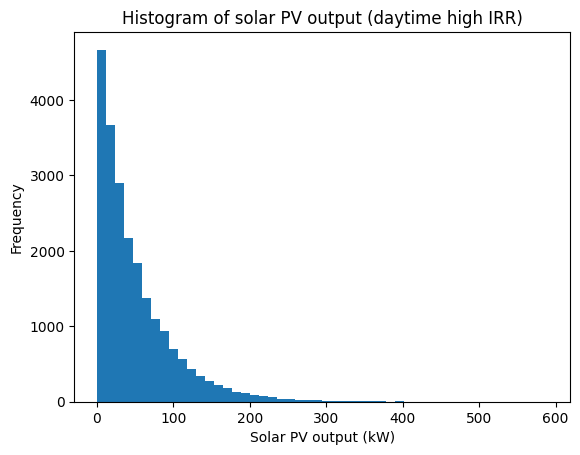

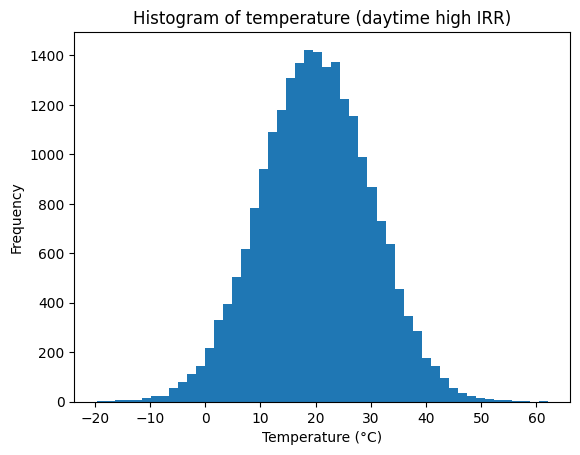

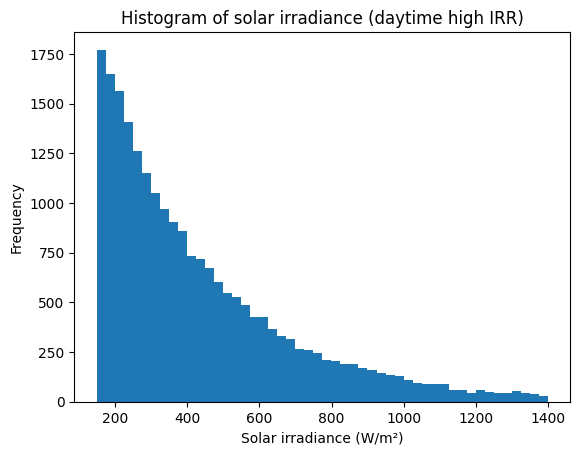

Max |off-diagonal correlation|: 0.0139


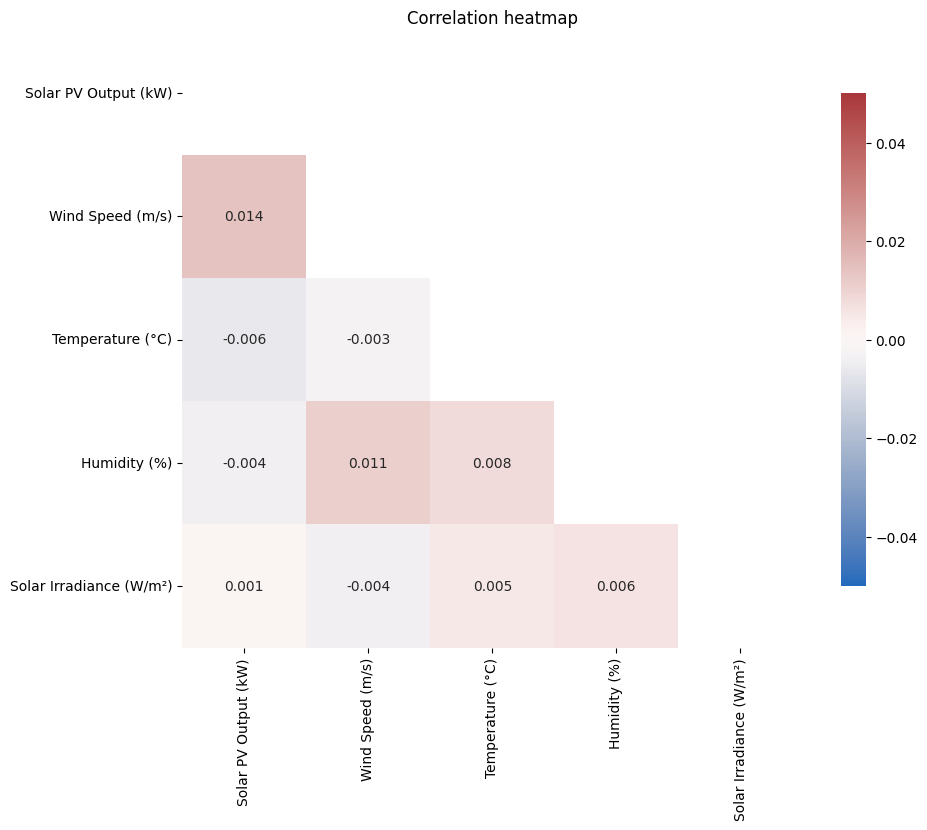

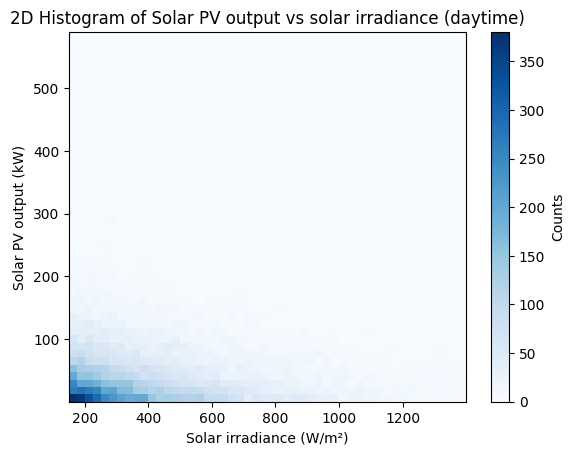

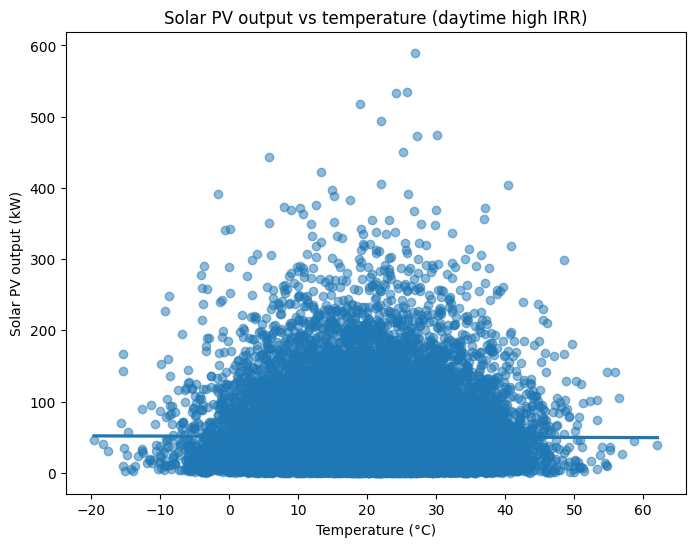

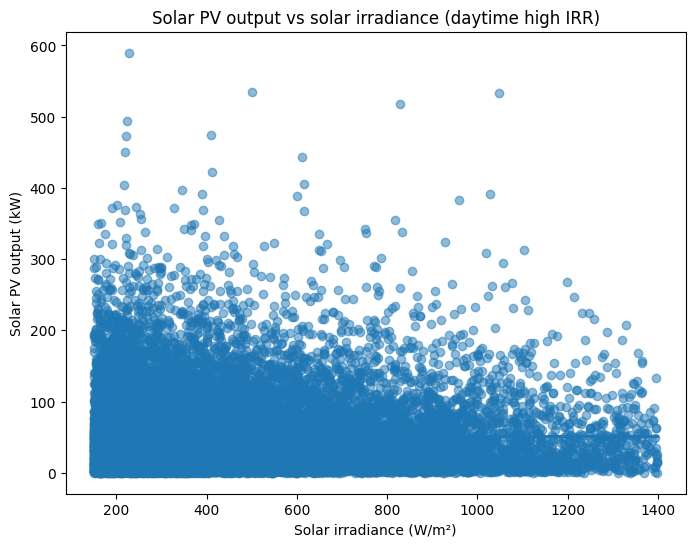

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from astral import LocationInfo
from astral.sun import sun
import pytz

# read csv file "USA_high_IRR.csv" and normalize whitespace
df = pd.read_csv("USA_high_IRR.csv", skipinitialspace=True)
df.columns = df.columns.str.strip()

# parse and clean timestamps first
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp']).sort_values('Timestamp')

# remove nighttime rows using Boston sunrise/sunset
boston = LocationInfo(name="Boston", region="USA", timezone="US/Eastern", latitude=42.3601, longitude=-71.0589)
eastern = pytz.timezone(boston.timezone)
df['Timestamp'] = df['Timestamp'].dt.tz_localize(eastern, nonexistent="shift_forward", ambiguous="NaT")
df = df.dropna(subset=['Timestamp']).reset_index(drop=True)

sun_cache = {}
def is_daylight(ts: pd.Timestamp) -> bool:
    if pd.isna(ts):
        return False
    day_key = ts.date()
    if day_key not in sun_cache:
        sun_cache[day_key] = sun(boston.observer, date=day_key, tzinfo=eastern)
    times = sun_cache[day_key]
    return times['sunrise'] <= ts <= times['sunset']

df = df[df['Timestamp'].apply(is_daylight)].reset_index(drop=True)

# drop physically impossible irradiance values and clip negatives
if 'Solar Irradiance (W/m²)' in df.columns:
    df = df[df['Solar Irradiance (W/m²)'].between(0, 1400)].reset_index(drop=True)

# coerce numeric columns and drop rows with missing key metrics
core_cols = [
    'Solar PV Output (kW)',
    'Wind Speed (m/s)',
    'Temperature (°C)',
    'Humidity (%)',
    'Solar Irradiance (W/m²)'
]
for col in core_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.strip(), errors='coerce')
present_core_cols = [col for col in core_cols if col in df.columns]
df = df.dropna(subset=present_core_cols).reset_index(drop=True)

print(df[present_core_cols].describe())

# histogram of Solar PV Output (kW)
plt.hist(df['Solar PV Output (kW)'], bins=50)
plt.xlabel('Solar PV output (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of solar PV output (daytime high IRR)')
plt.show()

# histogram of Temperature (°C)
plt.hist(df['Temperature (°C)'], bins=50)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of temperature (daytime high IRR)')
plt.show()

# histogram of Solar Irradiance (W/m²)
plt.hist(df['Solar Irradiance (W/m²)'], bins=50)
plt.xlabel('Solar irradiance (W/m²)')
plt.ylabel('Frequency')
plt.title('Histogram of solar irradiance (daytime high IRR)')
plt.show()

# Prepare numeric columns for correlation (Timestamp removed)
numeric_df = df.drop(columns=['Timestamp'], errors='ignore')
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
numeric_df = numeric_df.dropna(axis=1, how='all')
correlation_matrix = numeric_df.corr(method='pearson')

# dynamically scale color range so tiny correlations remain visible
if correlation_matrix.size > 0:
    mask = np.ones_like(correlation_matrix, dtype=bool)
    np.fill_diagonal(mask, False)
    max_abs_off_diag = float(np.abs(correlation_matrix.values[mask]).max()) if mask.any() else 0.0
else:
    max_abs_off_diag = 0.0
color_cap = max(0.05, max_abs_off_diag)
print(f"Max |off-diagonal correlation|: {max_abs_off_diag:.4f}")

plt.figure(figsize=(10, 8))
mask= np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    correlation_matrix.round(3),
    annot=True,
    cmap='vlag',
    fmt=".3f",
    center=0,
    vmin=-color_cap,
    vmax=color_cap,
    mask=mask,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation heatmap')
plt.show()

# 2D histogram Solar Irradiance vs Solar PV Output
plt.hist2d(df['Solar Irradiance (W/m²)'], df['Solar PV Output (kW)'], bins=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Solar irradiance (W/m²)')
plt.ylabel('Solar PV output (kW)')
plt.title('2D Histogram of Solar PV output vs solar irradiance (daytime)')
plt.show()

USA solar analysis low irr

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#read csv file "USA_low_irr.csv"
df = pd.read_csv("USA_low_irr.csv")
print(df.describe())

#histogram of Solar PV Output (kW)
plt.hist(df['Solar PV Output (kW)'], bins=50)
plt.xlabel('Solar PV output (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of solar PV output (Low IRR)')
plt.show()

#histogram of Temperature (°C)
plt.hist(df['Temperature (°C)'], bins=50)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of temperature (Low IRR)')
plt.show()

#histogram of Solar Irradiance (W/m2)
plt.hist(df['Solar Irradiance (W/m²)'], bins=50)
plt.xlabel('Solar irradiance (W/m²)')
plt.ylabel('Frequency')
plt.title('Histogram of solar irradiance (Low IRR)')
plt.show()

#correlation heatmap with all the data
correlation_matrix = df.drop(columns=['Timestamp'], errors='ignore').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap of Massachusett solar dataset')
plt.show()


       Solar PV Output (kW)  Wind Speed (m/s)  Temperature (°C)  Humidity (%)  \
count          28618.000000      28618.000000      28618.000000  28618.000000   
mean              49.707871          5.006736         20.027988     28.428120   
std               50.128830          5.008856         10.036178     15.949972   
min                0.002366          0.000113        -19.453645      0.079897   
25%               14.297829          1.437234         13.193602     16.045322   
50%               34.202644          3.450885         20.081334     26.194542   
75%               68.277480          6.936444         26.850373     38.654396   
max              540.785198         54.850535         59.206527     90.533259   

       Solar Irradiance (W/m²)  
count             28618.000000  
mean                 68.612328  
std                  43.066154  
min                   0.009583  
25%                  30.906463  
50%                  65.002243  
75%                 104.674982  
max   

'\n#histogram of Solar PV Output (kW)\nplt.hist(df[\'Solar PV Output (kW)\'], bins=50)\nplt.xlabel(\'Solar PV output (kW)\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of solar PV output (Low IRR)\')\nplt.show()\n\n#histogram of Temperature (°C)\nplt.hist(df[\'Temperature (°C)\'], bins=50)\nplt.xlabel(\'Temperature (°C)\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of temperature (Low IRR)\')\nplt.show()\n\n#histogram of Solar Irradiance (W/m2)\nplt.hist(df[\'Solar Irradiance (W/m²)\'], bins=50)\nplt.xlabel(\'Solar irradiance (W/m²)\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of solar irradiance (Low IRR)\')\nplt.show()\n\n#correlation heatmap with all the data\ncorrelation_matrix = df.drop(columns=[\'Timestamp\'], errors=\'ignore\').corr()\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap=\'coolwarm\', fmt=".2f")\nplt.title(\'Correlation heatmap of Massachusett solar dataset\')\nplt.show()\n'